In [1]:
import os
import random
from matplotlib import pyplot as plt
import cv2

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.metrics import Precision, Recall

import keras_tuner as kt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [2]:
top_dir = '/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset'

# Define the training paths
train_dir = os.path.join(top_dir, 'train')

# List all directories in the train directory
all_directories = os.listdir(train_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
train_human = []
train_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        train_ai.append(os.path.join(train_dir, directory))

# Print the lists of directories
print("Train directories containing human-drawn images:")
for i, directory in enumerate(train_human):
    print(f"{i}. {directory}")

print("\nTrain directories containing AI-generated images:")
for i, directory in enumerate(train_ai):
    print(f"{i}. {directory}")

Train directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/realism

Train directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/tr

In [3]:
# Define the test paths
test_dir = os.path.join(top_dir, 'test')

# List all directories in the test directory
all_directories = os.listdir(test_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
test_human = []
test_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        test_ai.append(os.path.join(test_dir, directory))

# Print the lists of directories
print("Test directories containing human-drawn images:")
for i, directory in enumerate(test_human):
    print(f"{i}. {directory}")

print("\nTest directories containing AI-generated images:")
for i, directory in enumerate(test_ai):
    print(f"{i}. {directory}")

Test directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/realism

Test directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_art_n

In [4]:
# Plot k-number of images from the dataset
def plot_im(directory, k):
    files = os.listdir(directory)
    im = random.choices(files, k=k)

    fig = plt.figure()

    for i in range(k):
        im_i_path = os.path.join(directory, im[i])  # File path
        im_i = cv2.imread(im_i_path)
        
        # Add subplot
        ax = fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        
        # Plot image
        ax.imshow(im_i)
        ax.axis('off')
        
        # Display filename below the image
        ax.set_title(im[i], fontsize=8, pad=2)

    plt.tight_layout()  # Adjust layout
    plt.show()

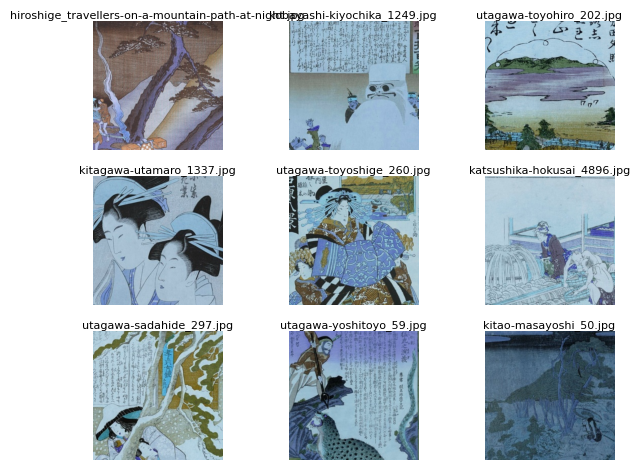

In [5]:
# Visualize random images from train_human. Catagory is sorted in order of output in cell 2
real_im = plot_im(directory=train_human[7], k=9)  
plt.show()

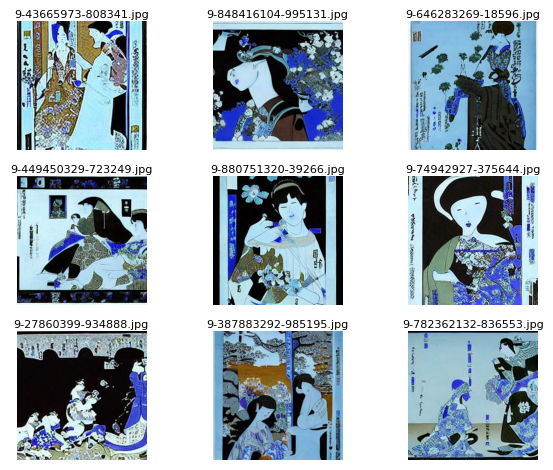

In [6]:
# Visualize random images from train_ai. Catagory is sorted in order of output in cell 2
ai_im = plot_im(directory=train_ai[4], k=9)  
plt.show()

In [7]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for train_data
train_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under train_human as "human"
for directory in train_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under train_ai as "AI"
for directory in train_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with train_data
train_data = pd.concat([train_data, data], ignore_index=True)

In [8]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human


In [9]:
# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("Number of files under each label:")
print(file_counts)

Number of files under each label:
label
AI       105015
human     50000
Name: count, dtype: int64


In [10]:
# Set the random seed for reproducibility
random_seed = 123  # Change this to your desired seed number
np.random.seed(random_seed)

# Number of rows to drop for the 'AI' label
num_to_drop = 55015

# Get the indices of rows with the 'AI' label
ai_indices = train_data[train_data['label'] == 'AI'].index

# Randomly select indices to drop using the specified seed
indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)

# Drop the selected rows from the DataFrame
train_data = train_data.drop(indices_to_drop)

# Reset the index of the DataFrame after dropping rows
train_data.reset_index(drop=True, inplace=True)

In [11]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
human    50000
AI       50000
Name: count, dtype: int64


In [12]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for test_data
test_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under test_human as "human"
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under test_ai as "AI"
for directory in test_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with test_data
test_data = pd.concat([test_data, data], ignore_index=True)

In [13]:
# Display the first few rows of the test_data DataFrame
print(test_data.head())

# Count the number of files under each label
file_counts = test_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
AI       20000
human    10000
Name: count, dtype: int64


In [14]:
training_generator = ImageDataGenerator(rescale=1./255,   # to normalize pixel value
                                       # rotation_range=7, # it will apply rotations to the image
                                       # horizontal_flip=True, # it will flip image horizontally
                                       # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
                                       )
train_dataset = training_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

Found 100000 validated image filenames belonging to 2 classes.


In [15]:
train_dataset.class_indices

{'AI': 0, 'human': 1}

In [16]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_dataframe(  dataframe=test_data,
                                                    x_col='filepath',  # Column containing file paths
                                                    y_col='label',     # Column containing labels
                                                    target_size = (32, 32),
                                                    batch_size = 1,    # 1 image at a time to evaluate the NN
                                                    class_mode = 'categorical',
                                                    shuffle = False)   # to associate the prediction with expected output

test_dataset.class_indices

Found 30000 validated image filenames belonging to 2 classes.


{'AI': 0, 'human': 1}

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [18]:
# Define the Compact Convolutional Transformer (CCT) Model
def create_cct_model(input_shape=(32, 32, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Second convolutional block
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Calculate number of patches
    patch_size = 4
    height, width, _ = input_shape
    num_patches = (height // patch_size) * (width // patch_size)  # Calculate number of patches
    embed_dim = 64

    # Apply Patch Embedding (Dense layer to embed each patch)
    x = layers.Dense(embed_dim)(x)

    # Reshape into patches (after applying dense layer, reshape into patches)
    x = layers.Reshape((num_patches, embed_dim))(x)  # Reshape the tensor into patches

    # Transformer Encoder Layer
    num_heads = 4
    mlp_dim = 128
    dropout_rate = 0.1

    # Add multiple transformer layers
    for _ in range(4):  # 4 transformer blocks
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x1, x1)
        x2 = layers.Add()([x, attention_output])
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp_output = keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
            layers.Dropout(dropout_rate),
        ])(x2)
        x = layers.Add()([x2, mlp_output])

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Build model
    model = keras.Model(inputs, outputs)
    return model

In [19]:
# Create model
cct_model = create_cct_model()

In [20]:
# Compile model
cct_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", Precision(), Recall()])

In [21]:
# Print model summary
cct_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8, 8, 64)       │          8,256 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 64)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 64)         │            128 │ reshape[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 64, 64)         │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64)         │              0 │ reshape[0][0],         │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 64, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64, 64)         │         16,576 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64)         │              0 │ layer_normalization_1… │
│                           │                        │                │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 64, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 64, 64)         │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├──────────────────────

 Total params: 416,834 (1.59 MB)

 Trainable params: 416,834 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

In [23]:
# Train the model
history = cct_model.fit(train_dataset,
                        epochs=15,
                        validation_data=test_dataset,
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1676s 1s/step - accuracy: 0.7621 - loss: 0.4766 - precision: 0.7621 - recall: 0.7621 - val_accuracy: 0.8841 - val_loss: 0.2745 - val_precision: 0.8841 - val_recall: 0.8841 - learning_rate: 1.0000e-04
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 472s 301ms/step - accuracy: 0.8827 - loss: 0.2757 - precision: 0.8827 - recall: 0.8827 - val_accuracy: 0.9173 - val_loss: 0.2025 - val_precision: 0.9173 - val_recall: 0.9173 - learning_rate: 1.0000e-04
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 449s 287ms/step - accuracy: 0.9046 - loss: 0.2300 - precision: 0.9046 - recall: 0.9046 - val_accuracy: 0.9242 - val_loss: 0.1853 - val_precision: 0.9242 - val_recall: 0.9242 - learning_rate: 1.0000e-04
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 417s 266ms/step - accuracy: 0.9140 - loss: 0.2090 - precision: 0.9140 - recall: 0.9140 - val_accuracy: 0.8940 - val_loss: 0.2495 - val_precision: 0.8940 - val_recall: 0.8940 - learning_rate: 1.0000e-04
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━

In [24]:
# Evaluate model
test_loss, test_acc, test_prec, test_rec = cct_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")


30000/30000 ━━━━━━━━━━━━━━━━━━━━ 108s 4ms/step - accuracy: 0.9142 - loss: 0.1977 - precision: 0.9142 - recall: 0.9142
Test Accuracy: 0.9437, Precision: 0.9437, Recall: 0.9437


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Get true labels and predicted labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # True labels
y_pred_probs = cct_model.predict(test_dataset)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded labels to class indices

In [ ]:
# **2. Print Classification Report**
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

In [ ]:
# **3. Compute Confusion Matrix**
conf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
# **4. Plot Confusion Matrix**
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
cct_model.save("cct_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("cct_model.h5")

# Verify it works by evaluating or predicting
# Example: loaded_model.evaluate(test_dataset)

In [ ]:
cct_model.save_weights("cct_weights.h5")
cct_model.load_weights("cct_weights.h5")